In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
from itertools import chain

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import pydicom
import skimage


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4789,00025181_006.png,Infiltration,6,25181,054Y,M,PA,2874,2550,0.143,0.143
4454,00022173_000.png,Pleural_Thickening,0,22173,067Y,M,PA,2992,2991,0.143,0.143
2403,00012098_000.png,No Finding,0,12098,047Y,F,PA,2690,2889,0.143,0.143


In [3]:
## Making a copy of the existent NIH data for the EDA
df = all_xray_df.copy()

In [4]:
## EDA
## Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
30161,00007864_007.png,Edema,7,7864,47,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30890,00008045_002.png,Atelectasis|Pneumonia,2,8045,59,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
95431,00025085_010.png,Infiltration|Pneumothorax,10,25085,24,M,PA,2694,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Demographic EDA

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

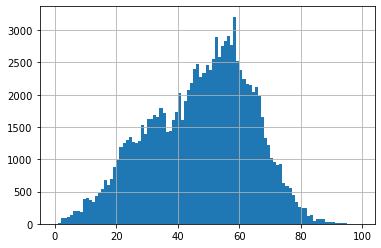

In [5]:
# Age
df['Patient Age'].hist(bins=np.arange(0,100,1))
df['Patient Age'].describe()

Patient Gender
F    48780
M    63340
Name: Patient ID, dtype: int64

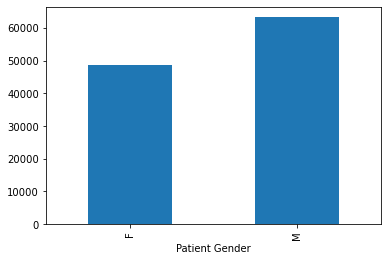

In [6]:
# Gender
gender_count = df.groupby(['Patient Gender'])['Patient ID'].count()
gender_count.plot(kind='bar')

# This line is just added to make a better visualisation
df.groupby(['Patient Gender'])['Patient ID'].count()

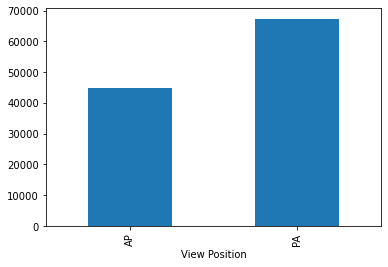

In [7]:
# View Patient Position
df.groupby(['View Position'])['Patient ID'].count()
df.groupby(['View Position'])['Patient ID'].count().plot(kind='bar')

In [8]:
# Labels frequency
df[all_labels].sum()/len(df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

In [9]:
# Labels number of cases
df[all_labels].sum()

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

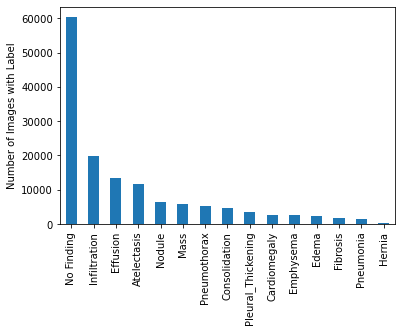

In [10]:
# Labels frequency Histogram
labels_hist = df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')
labels_hist.set(ylabel = 'Number of Images with Label')

It seem the label "No Finding" is the most common with 54% of frequency, followed by the "Infiltration" and "Effusion". 
The idea now is to explore the co-common diseases

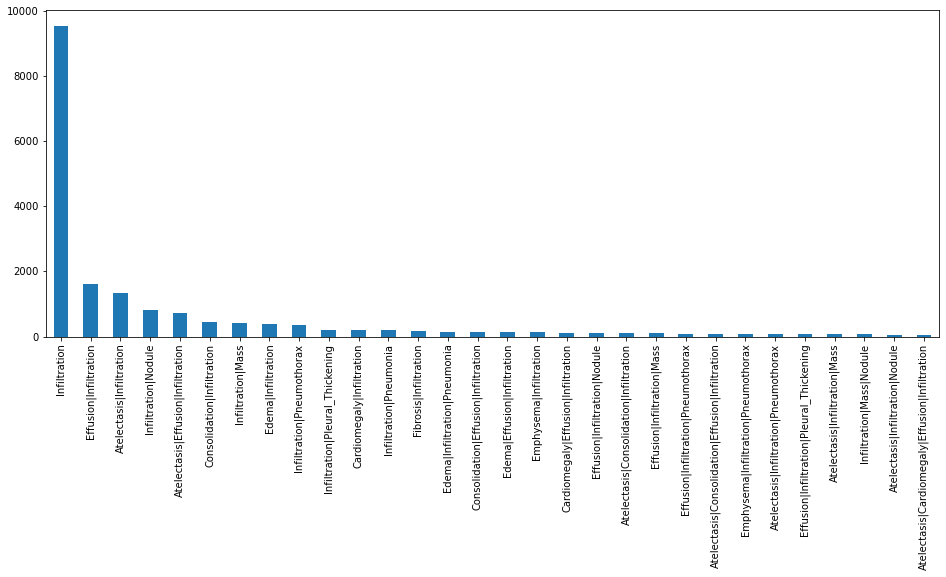

In [11]:
#Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
df[df.Infiltration==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

## Now I am going to explore more the Pneumonia cases

In [12]:
# Number of Pneumonia Cases and Non-Cases
positive_pneumonia = df[df.Pneumonia==1]['Patient ID'].value_counts().sum()
negative_pneumonia = df[df.Pneumonia==0]['Patient ID'].value_counts().sum()

print("Cases of POSITIVE diagnostic for Pneumonia: ", positive_pneumonia)
print("Cases of NEGATIVE diagnostic for Pneumonia: ", negative_pneumonia)

Cases of POSITIVE diagnostic for Pneumonia:  1431
Cases of NEGATIVE diagnostic for Pneumonia:  110689


In [13]:
# Frequency of the Pneumonia using Patient Gender
total_pneumonia_gender = df[df.Pneumonia==1]['Patient Gender'].value_counts().sum()

pneumonia_frequency_by_gender = df[df.Pneumonia==1]['Patient Gender'].value_counts()/total_pneumonia_gender
pneumonia_frequency_by_gender

M    0.585604
F    0.414396
Name: Patient Gender, dtype: float64

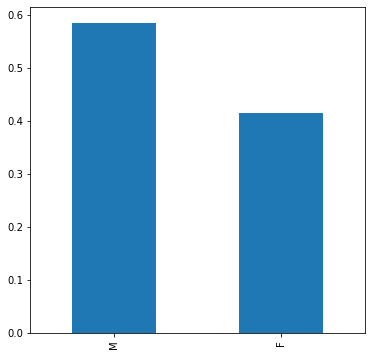

In [14]:
# Looking how Pneumonia affects patients by gender
plt.figure(figsize=(6,6))
pneumonia_frequency_by_gender.plot(kind='bar')

In [15]:
# Some statistic of the Pneumonia using Patient Age
df.groupby(['Pneumonia'])['Patient Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Pneumonia,,,,,,,,
0.0,110689.0,46.926985,16.791759,1.0,35.0,49.0,59.0,414.0
1.0,1431.0,44.927324,20.129866,2.0,31.0,46.0,59.0,412.0


The idea here is to understand how distributed are my cases along the ages. I can see some data error with the max of old age. This is why we shouldn't use the mean without seing the others statitics values.

(array([ 39.,  87., 190., 241., 251., 290., 252.,  67.,  13.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
 <a list of 9 Patch objects>)

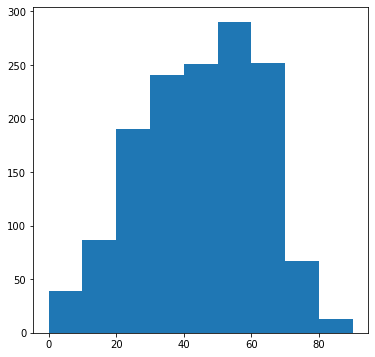

In [16]:
# Looking how Pneumonia affects patients by age
plt.figure(figsize=(6,6))
plt.hist(df[df.Pneumonia==1]['Patient Age'].values, bins=np.arange(0,100,10))

This histogram shows only the age distribution for the patients with Pneumonia. The age outliers where removed.

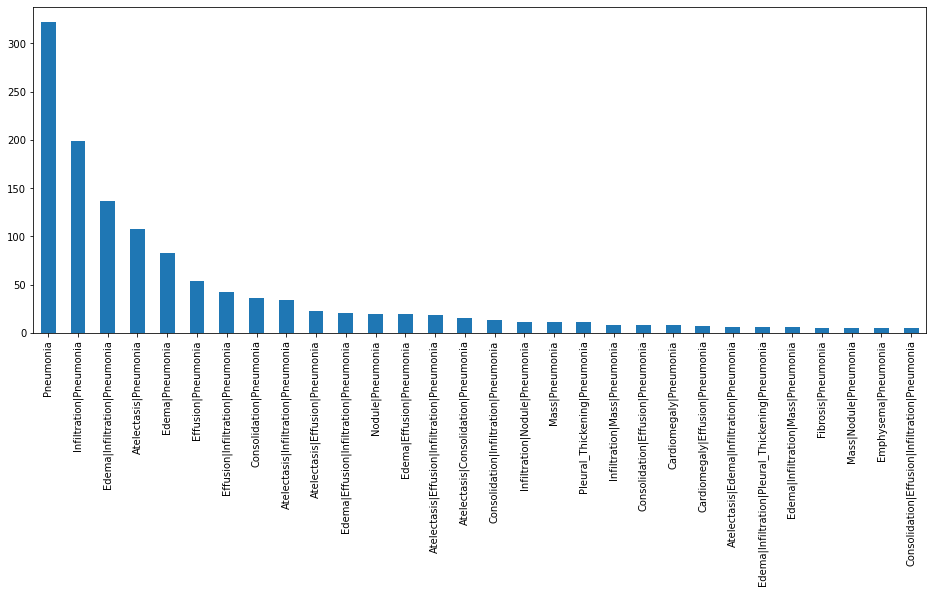

In [17]:
# Co-morbid cases of Pneumonia
# Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
df[df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

# The following analises will cover the image intensity analisys

## Analysing DICOM Images "No Findings" and "Effusion" since is the most co-morbid disease with Pneumonia

In [18]:
## Reading all DICOMs files
mydicoms = glob("*.dcm")
mydicoms

['test5.dcm', 'test2.dcm', 'test6.dcm', 'test4.dcm', 'test3.dcm', 'test1.dcm']

In [19]:
# Creating a DICOMs DF
all_data = []

for i in mydicoms: 
    dcm = pydicom.dcmread(i) #Read each DICOM file
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)
    
dicom_df = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])
dicom_df

,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns
0,2,81,M,CT,No Finding,1024,1024
1,1,58,M,DX,Cardiomegaly,1024,1024
2,2,81,M,DX,No Finding,1024,1024
3,2,81,M,DX,No Finding,1024,1024
4,61,77,M,DX,Effusion,1024,1024
5,2,81,M,DX,No Finding,1024,1024


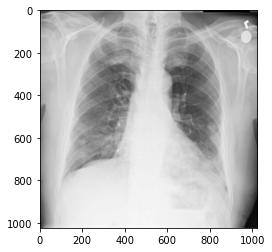

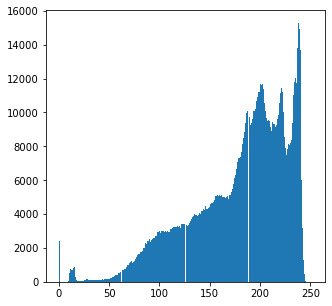

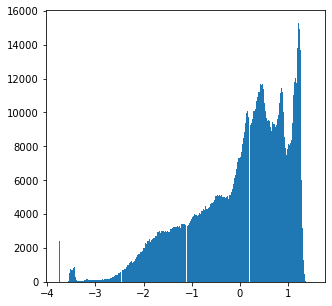

In [20]:
# Patient with "No Findings"
# Using the imshow to show the image based on the pixel_array
dcm_1 = pydicom.dcmread('test1.dcm')
dcm_1_array = dcm_1.pixel_array

#Plotting the images
plt.imshow(dcm_1_array,cmap='gray')
plt.show()

plt.figure(figsize=(5,5))
plt.hist(dcm_1_array.ravel(), bins=256)
plt.show()


# Making the normalization
dmc_1_mean = np.mean(dcm_1_array)
dcm_1_std= np.std(dcm_1_array)
new_dcm_1 = dcm_1_array.copy()
dcm_1_standard = (new_dcm_1 - dmc_1_mean)/dcm_1_std

plt.figure(figsize=(5,5))
plt.hist(dcm_1_standard.ravel(), bins=256)
plt.show()

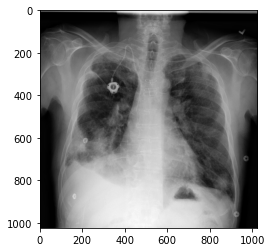

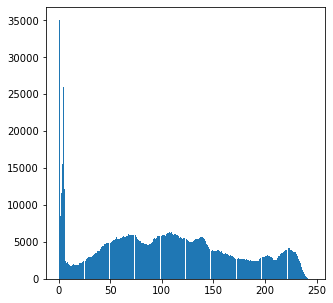

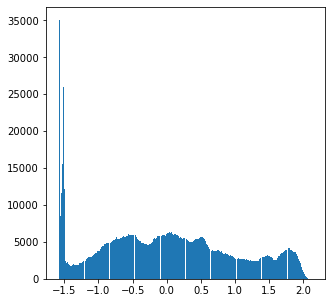

In [21]:
# Patient with "Effusion"
# Using the imshow to show the image based on the pixel_array
dcm_4 = pydicom.dcmread('test3.dcm')
dcm_4_array = dcm_4.pixel_array

#Plotting the images
plt.imshow(dcm_4_array,cmap='gray')
plt.show()

plt.figure(figsize=(5,5))
plt.hist(dcm_4_array.ravel(), bins=256)
plt.show()


# Making the normalization
dmc_4_mean = np.mean(dcm_4_array)
dcm_4_std= np.std(dcm_4_array)
new_dcm_4 = dcm_4_array.copy()
dcm_4_standard = (new_dcm_4 - dmc_4_mean)/dcm_4_std

plt.figure(figsize=(5,5))
plt.hist(dcm_4_standard.ravel(), bins=256)
plt.show()

Looking at both images, it seems that when an image are more clear it represents a "No Finding" label, but using just one image is not fair to reach a conclusion.
However it seems the comparison using only two images intensities are not enough to make a conclusion about how the model is going to be drawn.



## Analysis of Histogram Intensity in Patients with "No Findings" and "Pneumonia"

In [22]:
# To make the analysis more easier to understand, I am going to create some filter layers to my dataframe
no_findings = df[df['Finding Labels']=="No Finding"]
pneumonia = df[df.Pneumonia==1]
pneumonia_infiltration = df[df['Finding Labels']=="Infiltration|Pneumonia"]
pneumonia_infiltration_edema = df[df['Finding Labels']=="Edema|Infiltration|Pneumonia"]


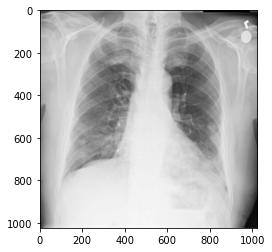

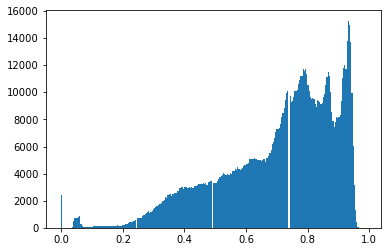

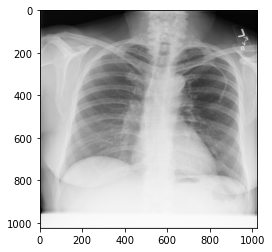

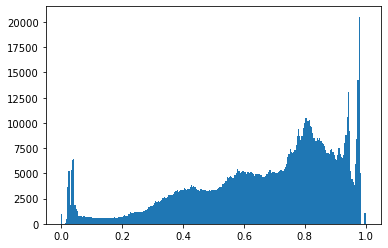

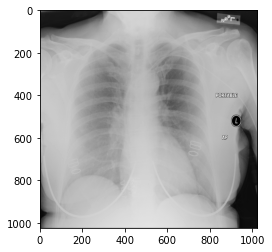

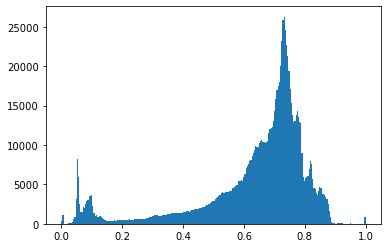

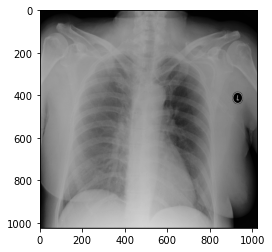

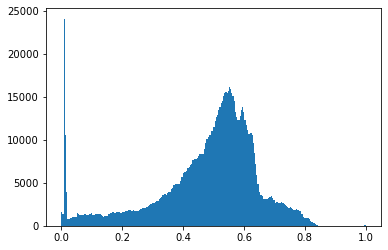

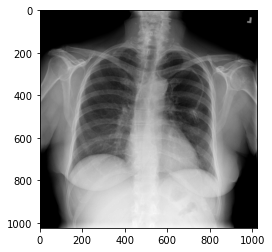

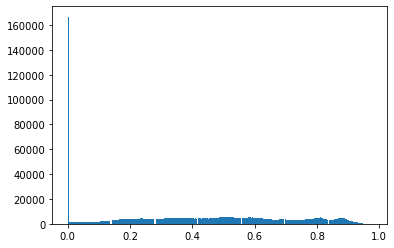

In [23]:
# Analysing the "No Finding" images
# The main idea was to bring a random images using the ".sample(5)" but the Workspace keeps freezing or couldn't find the file.

for i, row in no_findings.head(5).iterrows():
    filename = row['Image Index']
    image_file = plt.imread(os.path.join("/data/images_001/images/", filename))
    plt.imshow(image_file, cmap='gray')
    plt.show()
    
    plt.hist(image_file.ravel(), bins=256)
    plt.show()

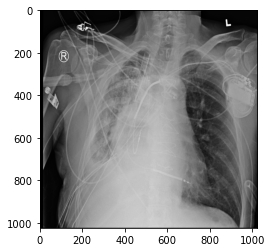

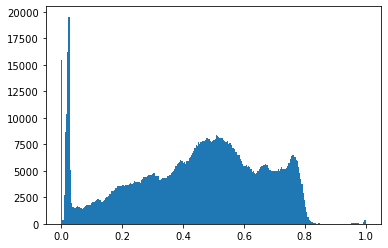

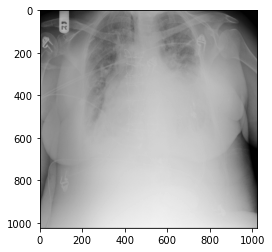

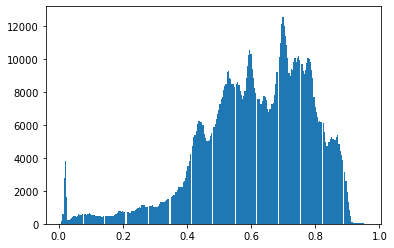

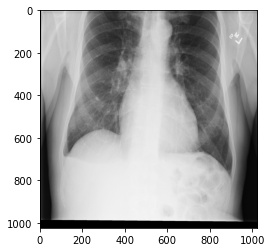

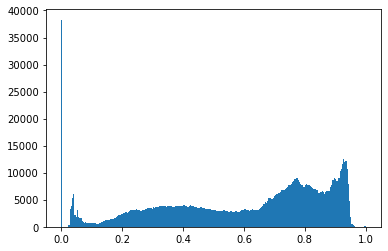

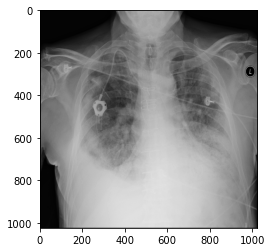

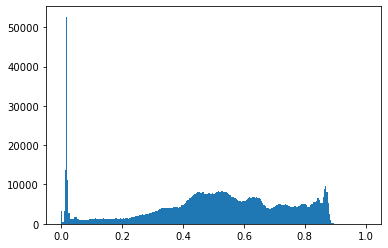

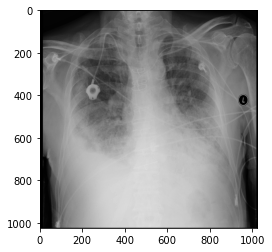

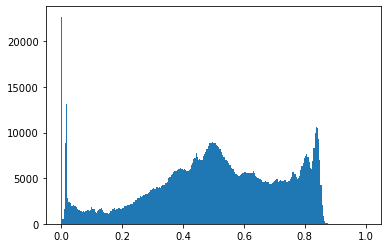

In [24]:
# Analysing the "Pneumonia" images
# The main idea was to bring a random images using the ".sample(5)" but the Workspace keeps freezing or couldn't find the file.

for i, row in pneumonia.head(5).iterrows():
    filename = row['Image Index']
    image_file = plt.imread(os.path.join("/data/images_001/images/", filename))
    plt.imshow(image_file, cmap='gray')
    plt.show()
    
    plt.hist(image_file.ravel(), bins=256)
    plt.show()

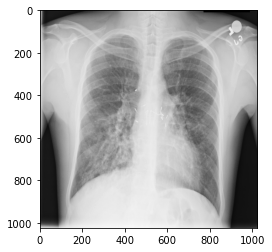

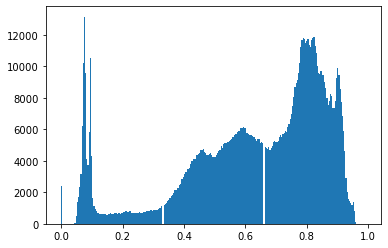

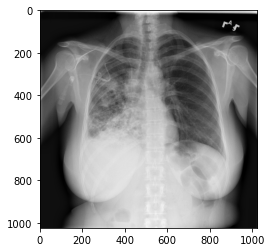

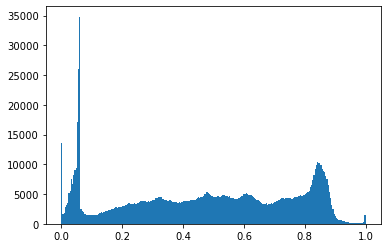

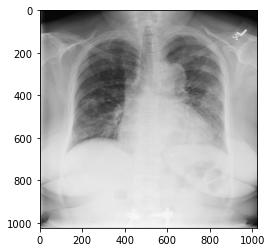

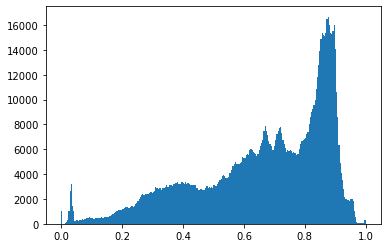

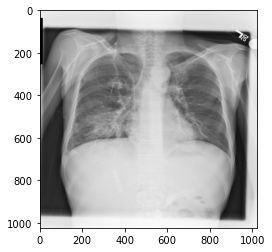

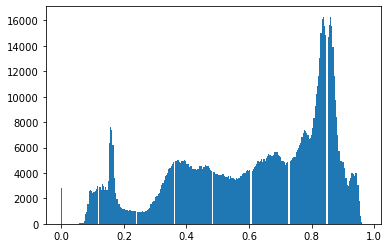

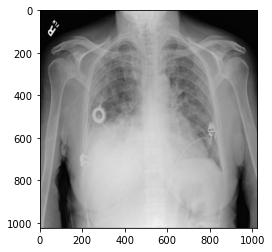

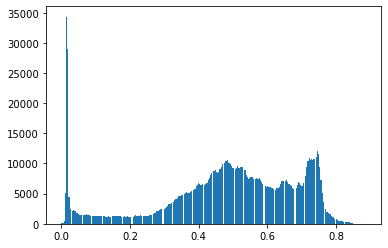

In [30]:
# Analysing the "Infiltration|Pneumonia" images
# The main idea was to bring a random images using the ".sample(5)" but the Workspace keeps freezing or couldn't find the file.

for i, row in pneumonia_infiltration.head(5).iterrows():
    filename = row['Image Index']
    image_file = plt.imread(os.path.join("/data/images_001/images/", filename))
    plt.imshow(image_file, cmap='gray')
    plt.show()
    
    plt.hist(image_file.ravel(), bins=256)
    plt.show()

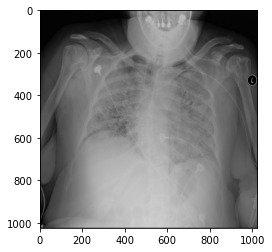

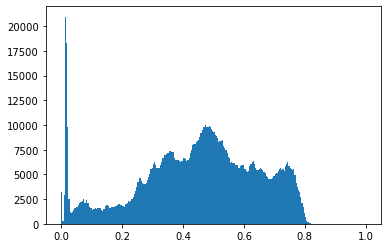

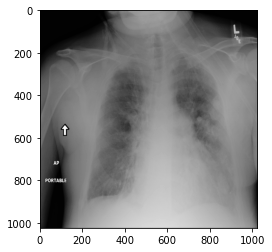

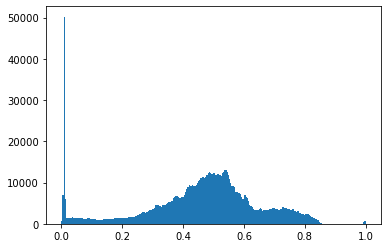

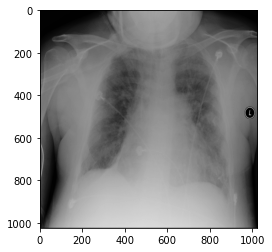

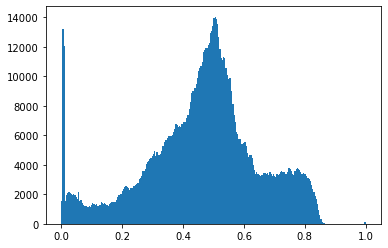

FileNotFoundError: [Errno 2] No such file or directory: '/data/images_001/images/00001836_052.png'

In [31]:
# Analysing the "Edema|Infiltration|Pneumonia" images
# The main idea was to bring a random images using the ".sample(5)" but the Workspace keeps freezing or couldn't find the file.

for i, row in pneumonia_infiltration_edema.head(5).iterrows():
    filename = row['Image Index']
    image_file = plt.imread(os.path.join("/data/images_001/images/", filename))
    plt.imshow(image_file, cmap='gray')
    plt.show()
    
    plt.hist(image_file.ravel(), bins=256)
    plt.show()

# Conclusions

- The DICOM image for "No Finding" shows tendency of brighter intensities, but the amount of DICOMs images were not enough to make a concrete conclusion about the model to be build in the Deep Leaning.
- Making an analysis towards the .png images provided, we still have some intensities differences even in the same labels images. That can be happening because of the image noises (wires, fatty tisues, patient movements, X-ray machine quality) but also because of the darker background that can be shown as peaks in the graphs. The insight I can have here is that most some of the Pneumonia (co-morbid or not) have a slightly peak of brighter intensities.
- However only with the intensity is not very clear to know which model I would build to detect the Pneumonia.
- An image reshape, augmentation or even the Otsu's method to remove the image noises can be very helpful to prepare those images for a ML or DL algorithm.